# Shapley Value Attribution for Sequential (LSTM) Models

This document presents a rigorous treatment of Shapley value attributions applied to Long Short-Term Memory (LSTM) neural networks. We elucidate the theoretical foundations, derive the formal definition for sequence data, describe unbiased Monte Carlo estimation of ground-truth values, and explain the adaptation of the SHAP DeepExplainer. Finally, we outline a methodology for comparative visualization and discuss the implications of interpretability in sequential models.

## 1. Introduction
Interpreting the contributions of individual inputs to a model’s prediction is critical for transparency in machine learning. While Shapley values are well established for static, tabular data, sequence models such as LSTMs pose a conceptual extension: each input element appears in temporal context. We treat each time–feature pair as an independent “player” in the Shapley game, enabling fair attribution across the entire sequence.

## 2. Formal Definition for Sequence Attributions

Let:

- $T$ denote the length of the input sequence  
- $F$ the feature dimension at each time step  
- $N_{\text{seq}} = \{(t, i) : t = 1, \dots, T;\ i = 1, \dots, F \}$ the set of all time–feature pairs  
- $x \in \mathbb{R}^{T \times F}$ a specific input sequence  
- $f : \mathbb{R}^{T \times F} \to \mathbb{R}$ the model’s scalar output  
- $b \in \mathbb{R}^{T \times F}$ the baseline sequence (e.g., empirical mean over reference set)

For any coalition $S \subseteq N_{\text{seq}}$, define the masked sequence $x_S$ by:

$$
x_S[t, i] =
\begin{cases}
x[t, i], & \text{if } (t, i) \in S \\
b[t, i], & \text{otherwise}
\end{cases}
$$

The Shapley value for the cell $(t, i)$ is:

$$
\phi_{t, i} =
\sum_{S \subseteq N_{\text{seq}} \setminus \{(t, i)\}}
\frac{|S|! \cdot (|N_{\text{seq}}| - |S| - 1)!}{|N_{\text{seq}}|!}
\left[ f(x_{S \cup \{(t, i)\}}) - f(x_S) \right]
$$

This ensures fair attribution across all possible input combinations and satisfies the axioms of efficiency, symmetry, nullity, and additivity.

## 3. Unbiased Monte Carlo Estimation

The exact summation spans $2^{T \cdot F}$ coalitions, which becomes intractable. We instead use a Monte Carlo estimator:

1. For each $(t, i)$ and $m = 1, \dots, M$, sample $S_m \subseteq N_{\text{seq}} \setminus \{(t, i)\}$ by including each other cell independently with probability 0.5  
2. Compute marginal contributions:  
   $$
   d_m = f(x_{S_m \cup \{(t, i)\}}) - f(x_{S_m})
   $$
3. Estimate:  
   $$
   \phi_{t, i}^{\text{MC}} \approx \frac{1}{M} \sum_{m=1}^M d_m
   $$

By the law of large numbers, $\phi_{t, i}^{\text{MC}} \to \phi_{t, i}$ as $M \to \infty$.

## 4. SHAP DeepExplainer Adaptation

SHAP DeepExplainer uses a background set $X_b = \{x'^{(1)}, \dots, x'^{(K)}\}$ to estimate:

$$
\mathbb{E}_{x' \sim X_b}[f(x')] \approx \frac{1}{K} \sum_{k=1}^K f(x'^{(k)})
$$

Then it computes attributions $\psi_{t, i}(x)$ satisfying:

$$
f(x) = \mathbb{E}[f(x')] + \sum_{t=1}^T \sum_{i=1}^F \psi_{t, i}(x)
$$

Nonlinear recurrent operations are linearized via Taylor expansion around each background sample, and backpropagation aggregates the contributions. For LSTM internals, `check_additivity=False` can be set to disable exact-sum checking if the model structure leads to slight mismatches.

## 5. Comparative Visualization Method

To compare $\phi^{\text{MC}}$ and $\psi$, we reshape both into $T \times F$ matrices and visualize using 3D bar charts:

- **Axes:** time index $t$, feature index $i$, attribution magnitude  
- **Left Plot:** Monte Carlo estimate $\phi_{t, i}^{\text{MC}}$  
- **Right Plot:** SHAP DeepExplainer attribution $\psi_{t, i}$

A close match between surfaces indicates high fidelity of the approximation.

## 6. Discussion and Conclusion

This exposition extends Shapley values to sequential models by treating time–feature positions as individual contributors. Monte Carlo sampling yields unbiased attributions, while DeepExplainer offers efficient, differentiable approximations. Visualization of attribution surfaces enables interpretation of temporal dynamics and helps validate explainer reliability.


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Running Deep...
Running Gradient...
Running Kernel...


100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


Running Partition...
Running CASHAP...
[CASHAP Additivity] sum(SHAP)=-0.2866 | Model diff=-0.2866


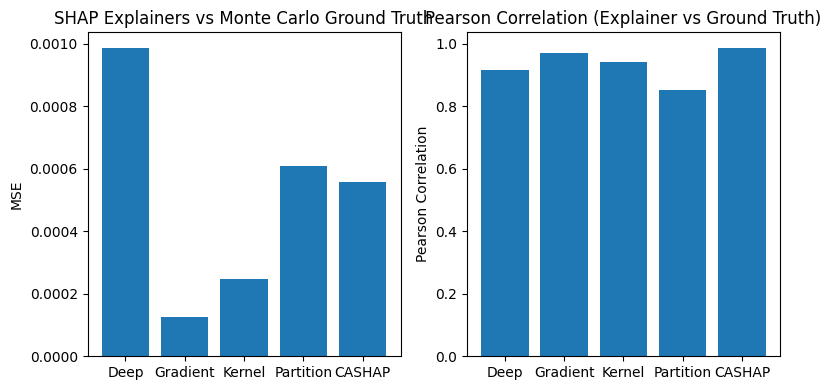

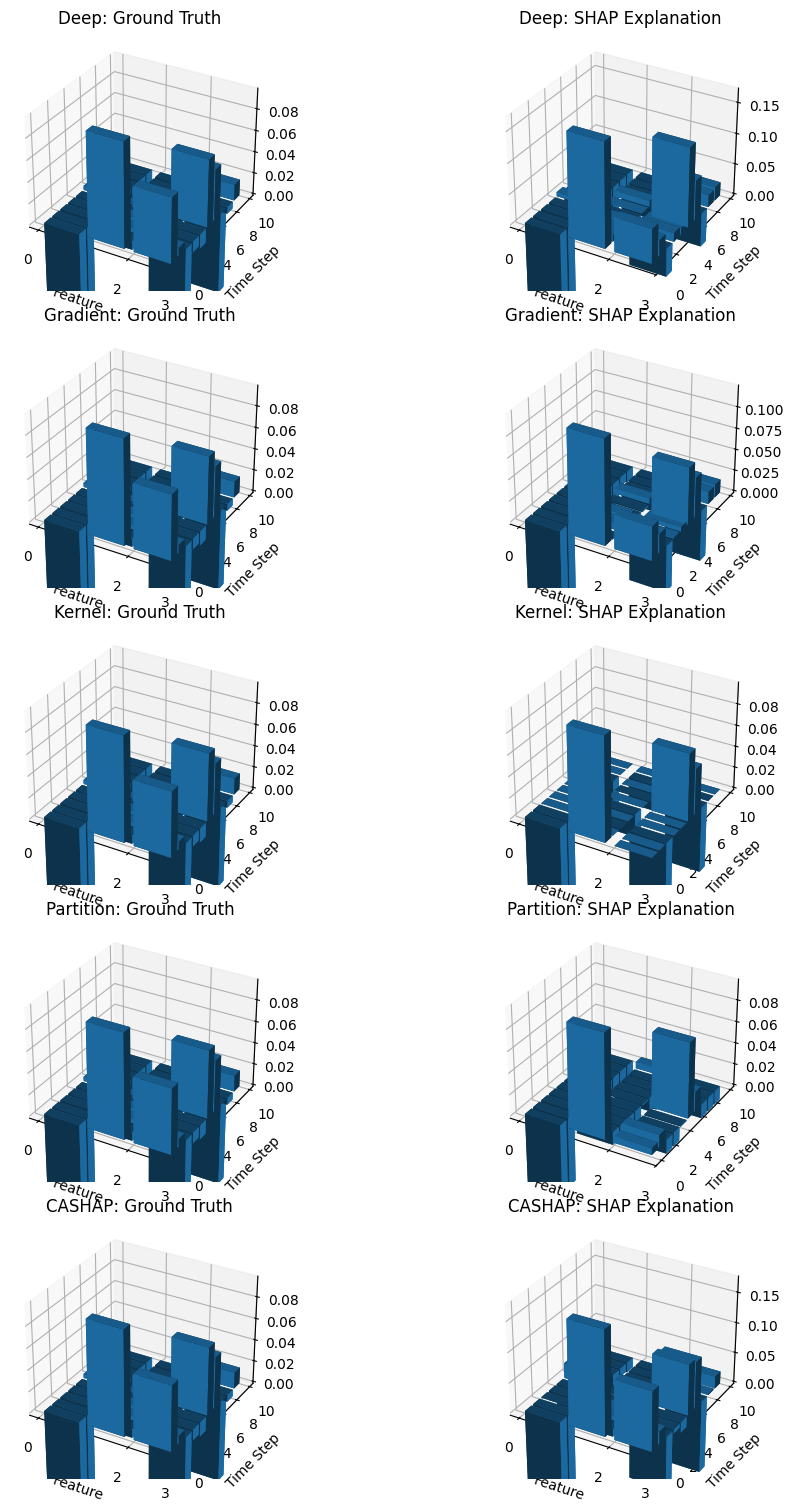

In [1]:
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr

from shap_enhanced.explainers.CASHAP import CoalitionAwareSHAPExplainer

# 1. Realistic LSTM model
class RealisticLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.attn_fc = nn.Linear(hidden_dim * 2, 1)  # attention over time
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # (B, T, 2*H)
        attn_weights = torch.softmax(self.attn_fc(out).squeeze(-1), dim=1)  # (B, T)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)        # (B, 2*H)
        context = self.dropout(context)
        return self.head(context)

# 2. Synthetic data
seq_len = 10
n_features = 3
n_samples = 200

X = np.random.randn(n_samples, seq_len, n_features)
y = np.sin(X[:, :, 0].sum(axis=1)) + 0.1 * np.random.randn(n_samples)

# 3. Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RealisticLSTM(input_dim=n_features).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_t = torch.tensor(X, dtype=torch.float32).to(device)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

model.train()
for epoch in range(100):
    opt.zero_grad()
    loss = loss_fn(model(X_t), y_t)
    loss.backward()
    opt.step()

# 4. Test + baseline
x_test = X[0]
x_baseline = X.mean(0)

# 5. Ground-truth SHAP values via Monte Carlo
def compute_shapley_gt(model, x, baseline, nsamples=200):
    T, F = x.shape
    vals = np.zeros((T, F))
    model.eval()
    with torch.no_grad():
        for t in range(T):
            for f in range(F):
                diffs = []
                for _ in range(nsamples):
                    mask = np.random.rand(T, F) < 0.5
                    m_with = mask.copy(); m_with[t, f] = True
                    m_without = mask.copy(); m_without[t, f] = False

                    def apply_mask(m):
                        xm = baseline.copy()
                        xm[m] = x[m]
                        inp = torch.tensor(xm[None], dtype=torch.float32).to(device)
                        return model(inp).cpu().numpy().squeeze()

                    y0 = apply_mask(m_without)
                    y1 = apply_mask(m_with)
                    diffs.append(y1 - y0)
                vals[t, f] = np.mean(diffs)
    return vals

shap_gt = compute_shapley_gt(model, x_test, x_baseline)

# 6. Define SHAP input functions
def f_numpy(flat_x):
    x = flat_x.reshape(-1, seq_len, n_features)
    with torch.no_grad():
        return model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().numpy()

bg_flat = X[:50].reshape(50, -1)
background_pt = torch.tensor(X[:50], dtype=torch.float32).to(device)

# 7. Instantiate explainers
explainers = {
    "Deep":      shap.DeepExplainer(model, background_pt),
    "Gradient":  shap.GradientExplainer(model, background_pt),
    "Kernel":    shap.KernelExplainer(f_numpy, bg_flat),
    "Partition": shap.PartitionExplainer(f_numpy, bg_flat),
    "CASHAP":    CoalitionAwareSHAPExplainer(
        model=model, 
        background=X[:50],  # or background_pt.cpu().numpy()
        mask_strategy="mean",  # or "zero"
        device=device
    ),
}

# 8. Helper: reshape SHAP output
def reshape_shap_arr(arr):
    return arr.reshape(seq_len, n_features)

# 9. Compute SHAP values
shap_models = {}
for name, expl in explainers.items():
    print(f"Running {name}...")
    if name in ["Deep", "Gradient"]:
        inp = torch.tensor(x_test[None], dtype=torch.float32, requires_grad=True).to(device)
        if name == "Deep":
            raw = expl.shap_values(inp, check_additivity=False)
        else:
            raw = expl.shap_values(inp)
        if isinstance(raw, list):
            raw = raw[0]
        arr = reshape_shap_arr(raw)
    elif name == "Kernel":
        raw = expl.shap_values(x_test.reshape(1, -1))
        arr = reshape_shap_arr(raw)
    elif name == "Partition":
        out = expl(x_test.reshape(1, -1))
        arr = reshape_shap_arr(out.values[0])
    elif name == "CASHAP":
        # Call your explainer
        arr = expl.shap_values(x_test, nsamples=20, coalition_size=6)  # adjust nsamples as needed for speed/quality
    else:
        raise NotImplementedError(f"Unknown explainer: {name}")
    shap_models[name] = arr


# 10. MSE and Pearson comparison
results = {}
pearson_results = {}

for name, arr in shap_models.items():
    mse = np.mean((arr - shap_gt) ** 2)
    # Flatten arrays
    gt_flat = shap_gt.flatten()
    arr_flat = arr.flatten()
    # Pearson correlation (handle edge case: if all zeros, correlation is undefined)
    try:
        pearson, _ = pearsonr(gt_flat, arr_flat)
    except Exception:
        pearson = np.nan
    results[name] = mse
    pearson_results[name] = pearson

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.bar(list(results.keys()), list(results.values()))
plt.ylabel("MSE")
plt.title("SHAP Explainers vs Monte Carlo Ground Truth")

plt.subplot(1,2,2)
plt.bar(list(pearson_results.keys()), list(pearson_results.values()))
plt.ylabel("Pearson Correlation")
plt.title("Pearson Correlation (Explainer vs Ground Truth)")

plt.tight_layout()
plt.show()

# 11. 3D bar plots
fig = plt.figure(figsize=(12, 3 * len(shap_models)))
for i, (name, arr) in enumerate(shap_models.items()):
    _x = np.arange(n_features)
    _y = np.arange(seq_len)
    xx, yy = np.meshgrid(_x, _y)
    xpos, ypos = xx.flatten(), yy.flatten()
    zpos = np.zeros_like(xpos)
    dx = dy = 0.8

    # Ground Truth
    ax_gt = fig.add_subplot(len(shap_models), 2, 2 * i + 1, projection='3d')
    dz_gt = shap_gt.flatten()
    ax_gt.bar3d(xpos, ypos, zpos, dx, dy, dz_gt)
    ax_gt.set_title(f"{name}: Ground Truth")
    ax_gt.set_xlabel('Feature')
    ax_gt.set_ylabel('Time Step')

    # Explainer Output
    ax_ex = fig.add_subplot(len(shap_models), 2, 2 * i + 2, projection='3d')
    dz_ex = arr.flatten()
    ax_ex.bar3d(xpos, ypos, zpos, dx, dy, dz_ex)
    ax_ex.set_title(f"{name}: SHAP Explanation")
    ax_ex.set_xlabel('Feature')
    ax_ex.set_ylabel('Time Step')

plt.tight_layout()
plt.show()
